In [1]:
import torch
import torch.nn as nn

import numpy as np
import copy

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [48]:
import importlib
import sine_data_generator

importlib.reload(sine_data_generator)
from sine_data_generator import SineDataGenerator

In [ ]:
data_gen = SineDataGenerator(10, 16)

inputs_np, outputs_np, amp_np, phase_np = data = data_gen.generate()
inputs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data]

In [ ]:
inputs.shape, outputs_pred.shape, amp.shape, phase.shape

(torch.Size([16, 10, 1]),
 torch.Size([16, 10, 1]),
 torch.Size([16]),
 torch.Size([16]))

### Modules

In [6]:
def relu_seq(sizes):
    layers = []
    d_input = sizes[0]

    for d_hidden in sizes[1:-1]:
        layers.append(nn.Linear(d_input, d_hidden))
        layers.append(nn.ReLU())
        d_input = d_hidden

    d_output = sizes[-1]
    layers.append(nn.Linear(d_input, d_output))  # output layer
    return layers


# TODO add dropout

class ReluNet(nn.Module):
    def __init__(self, *sizes):
        super().__init__()
        layers = relu_seq(sizes)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


#### Encoder

In [60]:
import torch
import torch.nn as nn

class IOPairSetEncoder(nn.Module):
    """DeepSet encoder for input-output pairs (N per batch)"""
    def __init__(self,
                 phi=ReluNet(2, 32, 32),
                 rho_0=ReluNet(32, 32, 16),
                 rho_1=ReluNet(16, 8, 3)):
        super().__init__()
        # Shared encoder phi
        self.phi = phi
        # Output processor rho
        self.rho_0 = rho_0
        self.rho_1 = rho_1
        self.rho_2 = copy.deepcopy(rho_1)

    def forward(self, x):
        # x: (B*, N, 2)
        x_phi = self.phi(x)                 # (B*, N, H)
        # sum over the N-axis (sum set elements' representations)
        x_sum = x_phi.sum(dim=-2)            # (B*, H)
        common = self.rho_0(x_sum)            # (B*, H)
        mu = self.rho_1(common)               # (B*, H)
        logvar = self.rho_2(common)
        return mu, logvar


In [ ]:
io_pairs = torch.cat([inputs, outputs_pred], dim=-1)  # (batch_size, N, 2)
io_pairs.shape

torch.Size([16, 10, 2])

In [ ]:
set_encoder = IOPairSetEncoder()
z_mu, z_logvar = set_encoder(io_pairs)
z_sample = z_mu
z_sample.shape  # (batch_size, output_dim)

torch.Size([16, 3])

In [11]:
set_encoder

IOPairSetEncoder(
  (phi): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (rho_0): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (rho_1): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
  (rho_2): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
)

#### Decoder

In [41]:
class Decoder(ReluNet):
    # TODO add a batchnorm

    def __init__(self, d_input=1, d_latent=3, ds_hidden=[32, 32], d_output=1):
        sizes = [d_latent + d_input] + ds_hidden + [d_output]
        super().__init__(*sizes)
        self.d_input = d_input
        self.d_latent = d_latent
        self.d_output = d_output


In [ ]:
z_sample.shape, inputs.shape

(torch.Size([16, 3]), torch.Size([16, 10, 1]))

In [17]:
input_0 = inputs[:, 0, :]  # (batch_size, d_input)
input_0.shape

torch.Size([16, 1])

In [ ]:
z_expanded = z_sample.unsqueeze(1).expand(-1, inputs.size(1), -1)
z_inputs = torch.cat([z_expanded, inputs], axis=-1)
z_inputs.shape

torch.Size([16, 10, 4])

In [19]:
decoder = Decoder()
decoder

Decoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [20]:
decoder(z_inputs).shape

torch.Size([16, 10, 1])

### Utils

In [21]:
def make_leave_one_out(array: torch.Tensor, axis: int) -> torch.Tensor:
    """
    Args:
        array: Tensor of shape (*B, N, *H).
        axis: The axis where N appears.

    Returns:
        Tensor of shape (*B, N, N-1, *H).
    """
    axis = axis % array.ndim
    n = array.size(axis)
    output = []

    for i in range(n):
        array_before = array.narrow(axis, 0, i)
        array_after = array.narrow(axis, i + 1, n - i - 1)
        sliced = torch.cat([array_before, array_after], dim=axis)
        output.append(sliced)

    output = torch.stack(output, dim=axis)
    return output

In [22]:
# Create a random tensor
random_array = torch.randn(4, 5, 6)  # Example shape (4, 5, 6)

# Apply the make_leave_one_out function
leave_one_out_result = make_leave_one_out(random_array, axis=1)

# Print the shapes to verify
print("Original shape:", random_array.shape)
print("Leave-one-out shape:", leave_one_out_result.shape)

Original shape: torch.Size([4, 5, 6])
Leave-one-out shape: torch.Size([4, 5, 4, 6])


In [23]:
random_array[0, :, :]

tensor([[-0.9767, -0.9691,  0.2880,  1.5877, -1.8979, -0.9450],
        [-0.8386,  0.9660,  0.9943, -0.8892,  0.3971, -1.3858],
        [-0.1369,  1.0822, -0.2521, -0.5015, -0.6334,  0.5998],
        [-0.7034,  0.2850,  0.0996, -0.0052,  0.1695, -0.0488],
        [-0.9866,  1.1247,  0.1873, -0.6212,  1.0650,  0.6567]])

In [24]:
leave_one_out_result[0, 0, :, :]

tensor([[-0.8386,  0.9660,  0.9943, -0.8892,  0.3971, -1.3858],
        [-0.1369,  1.0822, -0.2521, -0.5015, -0.6334,  0.5998],
        [-0.7034,  0.2850,  0.0996, -0.0052,  0.1695, -0.0488],
        [-0.9866,  1.1247,  0.1873, -0.6212,  1.0650,  0.6567]])

### [WIP] LPN

In [ ]:
class LPN(nn.Module):
    def __init__(self,
                 d_input,
                 d_output,
                 d_latent,
                 encoder,
                 decoder,
                 alpha=4e-4,
                 beta=1e-3,
                 loss_fn=nn.MSELoss()):
        """
        Args:
            d_input: Input dimension.
            d_output: Output dimension.
            d_latent: Latent dimension.
            encoder: Encoder module (e.g., IOPairSetEncoder).
            decoder: Decoder module (e.g., Decoder).
            alpha: Step size or learning rate in inner latent optimization.
            beta: "Prior KL Coeff". Weight for the KL divergence term.
        """
        super().__init__()
        self.d_input = d_input
        self.d_output = d_output
        assert self.d_input == self.d_output == 1, "Unsupported d_input or d_output"
        self.d_latent = d_latent
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha
        self.beta = beta
        self.mse = nn.MSELoss()


    def forward(self, pairs):

        # pairs: (B, N, 2)
        # Note: assuming d_input = d_output = 1
        # pairs_one_left_out: (B, N, N-1, 2)
        ## print(f"{pairs.shape=}")
        pairs_one_left_out = make_leave_one_out(pairs, axis=1)
        ## print(f"{pairs_one_left_out.shape=}")

        # Encode the context IO pairs (one-left-out) into a latent
        # z_mu, z_logvar: (B, N, H)
        z_mu, z_logvar = self.encoder(pairs_one_left_out)
        ## print(f"{z_mu.shape=}")

        assert z_mu.shape == z_logvar.shape
        b, n = pairs.size(0), pairs.size(1)
        assert z_mu.shape == (b, n, self.d_latent), f"{z_mu.shape} != {(b, n, self.d_latent)}"

        z_sample = self.sample_latents(z_mu, z_logvar)
        kl_loss = self.kl_divergence(z_mu, z_logvar)
        
        # TODO latent optimization

        # Decode the (target) inputs with the one-left-out latents into outputs
        inputs = pairs[:, :, 0].unsqueeze(-1) # (B, N, 1)
        z_inputs = torch.cat([z_sample, inputs], dim=-1)

        # outputs_pred: (B, N, 1)
        outputs_pred = self.decoder(z_inputs)

        outputs_true = pairs[:, :, 1].unsqueeze(-1)

        # NOTE: assuming a variance of 1. for intuition see https://chatgpt.com/share/6809ffa6-7710-8000-bef7-b73d0116c0e2
        recon_loss = .5 * self.mse(outputs_pred, outputs_true)

        # recon_loss is wrt the decoder (p_theta)
        # kl_loss is wrt the encoder (q_phi)
        loss = recon_loss + self.beta * kl_loss

        aux = {
            'z_mu': z_mu,
            'z_logvar': z_logvar,
            'z_sample': z_sample,
            'outputs_pred': outputs_pred,
        }

        return aux, loss


    def sample_latents(self, z_mu, z_logvar):
        std = torch.exp(0.5 * z_logvar)  # (B*, H)
        eps = torch.randn_like(std)      # (B*, H), same shape as std
        z = z_mu + eps * std             # (B*, H)
        return z


    def kl_divergence(self, z_mu, z_logvar):
        # KL divergence between N(z_mu, exp(z_logvar)) and N(0, I)
        kl = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp(), dim=-1)  # shape: (B*)
        return kl.mean()


    


### Scratch

In [36]:
pairs = io_pairs
pairs.shape
inputs = pairs[:, :, 0].unsqueeze(-1)
inputs.shape

torch.Size([16, 10, 1])

In [ ]:
.shape

torch.Size([16, 10, 2])

In [86]:
import wandb
wandb.init(settings=wandb.Settings(save_code=False))
wandb.finish()
wandb.init(project="lpn4sine")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_tasks = 10_000
n_samples_per_task = 10
batch_size = 16

data_gen = SineDataGenerator(n_samples_per_task, batch_size)

d_latent = 3
# alpha = .1

# Init encoder-decoder
encoder = IOPairSetEncoder(phi=ReluNet(2, 32, 32),
                           rho_0=ReluNet(32, 32, 16),
                           rho_1=ReluNet(16, 8, d_latent))
decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[32, 32], d_output=1)

lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)

optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)

losses = []

for i in range(n_tasks):
    lpn.train()
    optimizer.zero_grad()

    inputs, outputs, amp, phase = data_gen.generate()
    io_pairs = torch.cat([inputs, outputs], dim=-1).to(device)  # (B, N, 2)

    _, loss = lpn(io_pairs)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")
        wandb.log({"loss": loss.item()})
        losses.append(loss.item())


# wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Step 0, Loss: 1.8649
Step 100, Loss: 1.6359
Step 200, Loss: 1.3992
Step 300, Loss: 1.1134
Step 400, Loss: 0.7191
Step 500, Loss: 0.8832
Step 600, Loss: 1.9432
Step 700, Loss: 1.0000
Step 800, Loss: 1.1297
Step 900, Loss: 0.8340
Step 1000, Loss: 0.4546
Step 1100, Loss: 0.3921
Step 1200, Loss: 0.2046
Step 1300, Loss: 0.2622
Step 1400, Loss: 0.4622
Step 1500, Loss: 0.3320
Step 1600, Loss: 0.2915
Step 1700, Loss: 0.1681
Step 1800, Loss: 0.2650
Step 1900, Loss: 0.2658
Step 2000, Loss: 0.2120
Step 2100, Loss: 0.3424
Step 2200, Loss: 0.1828
Step 2300, Loss: 0.2655
Step 2400, Loss: 0.2169
Step 2500, Loss: 0.2613
Step 2600, Loss: 0.1917
Step 2700, Loss: 0.2164
Step 2800, Loss: 0.3400
Step 2900, Loss: 0.2876
Step 3000, Loss: 0.2562
Step 3100, Loss: 0.3525
Step 3200, Loss: 0.1943
Step 3300, Loss: 0.2661
Step 3400, Loss: 0.2627
Step 3500, Loss: 0.1538
Step 3600, Loss: 0.1498
Step 3700, Loss: 0.1445
Step 3800, Loss: 0.2201
Step 3900, Loss: 0.2453
Step 4000, Loss: 0.1070
Step 4100, Loss: 0.2922
Step

In [87]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


loss,█▇▅▅▃▁▂▂▂▁▂▁▁▁▁▂▂▂▁▂▁▁▂▂▁▁▂▁▃▂▂▁▁▁▂▁▁▂▁▁
loss,0.12293


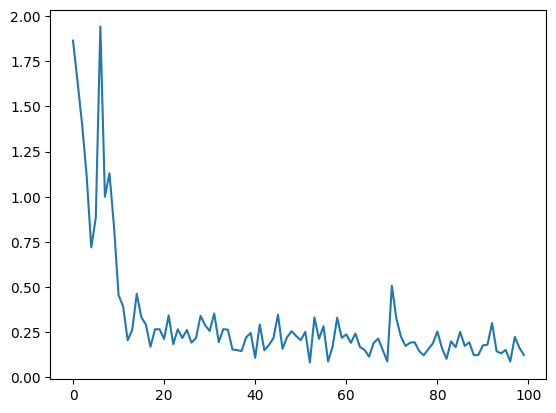

In [89]:
plt.plot(losses)
plt.show()

#### Micro-validation

In [70]:
inputs_t, outputs_t, amp_t, phase_t = SineDataGenerator(10, 1).generate()

In [73]:
inputs_t.shape, amp_t.shape

(torch.Size([1, 10, 1]), torch.Size([1]))

In [ ]:
io_pairs_t = torch.cat([inputs_t, outputs_t], dim=-1).to(device)  # (B, N, 2)
aux_t, loss_t = lpn(io_pairs_t)
outputs_pred_t = aux_t["outputs_pred"].detach().cpu().numpy()

In [84]:
amp_t.item()

3.3096280097961426

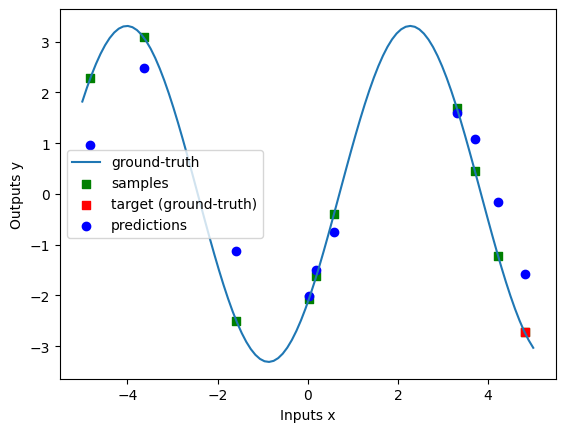

In [85]:
import matplotlib.pyplot as plt

# Plot ground-truth,
amp = amp_t.item()
phase = phase_t.item()

# Plot each set of inputs and outputs as a separate line
x = np.linspace(-5, 5, 100)
y = amp * np.sin(x - phase)

plt.plot(x, y, label=f"ground-truth")
plt.scatter(inputs_t, outputs_t, color='green', marker='s', label=f"samples")

target_input = inputs_t[0, 0, 0].item()
target_output = outputs_t[0, 0, 0].item()
plt.scatter(target_input, target_output, marker='s', color='red', label=f"target (ground-truth)")

plt.scatter(inputs_t, outputs_pred_t, marker='o', color='blue', label=f"predictions")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()

### [WIP] Algorithm 1: Test-Time Inference

In [ ]:
# # Input
# inputs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data_gen.generate()]
# # Context: n=10 input-output pairs (x_i, y_i)
# ctx_inputs = inputs[:, :-1, :]
# ctx_outputs = outputs_pred[:, :-1, :]
# # Test input x_{n+1}
# test_inputs = inputs[:, -1, :].unsqueeze(1)
# test_outputs = outputs_pred[:, -1, :].unsqueeze(1)
# number of gradient steps

### Plotting sample tasks

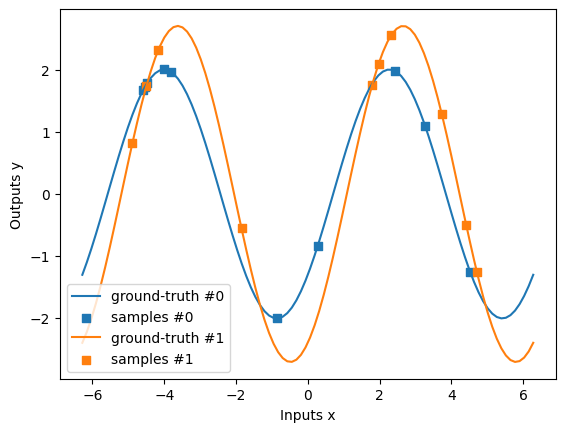

In [ ]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = amp_np[i] * np.sin(x - phase_np[i])
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")
    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()